In [1]:
import numpy as np
import xscen as xs
import cartopy.crs as ccrs
from xscen.config import CONFIG
import figanos.matplotlib as fg

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from plot_settings import PROJECTION, PAGE_HEIGHT, PAGE_WIDTH, DPI, make_standardizer, save_plot
standardize = make_standardizer()

import matplotlib.pyplot as plt

fg.utils.set_mpl_style('ouranos')

# Load configuration
xs.load_config(
    "../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True
)

2025-08-29 14:00:49 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-08-29 14:00:49 INFO     xscen.config    Updated the config with ../config_obs.yml.


In [2]:
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df

Processing variable: pr_mean_annual_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Detected annual data for pr_mean_annual_clim_mean - Horizon: 1981-2010
	Horizon: 1981-2010
Processing variable: pr_mean_seasonal_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
Processing variable: pr_mean_seasonal_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
Processing variable: tg_mean_annual_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Detected annual data for tg_mean_annual_clim_std - Horizon: 1981-2010
	Horizon: 1981-2010
	Horizon: 1991-2020
Processing variable: tg_mean_seasonal_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
	Horizon: 1991-2020
Processing variable: tg_mean_annual_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Detected annual data for tg_mean_annual_clim_mean - Horizon: 1981-2010
	Horizon: 1981-2010
	Horizon: 1991-2020
Processing variable: tg_mean_seasonal_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
	Horizon: 1991-2020
Processing variable: pr_mean_annual_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Detected annual data for pr_mean_annual_clim_std - Horizon: 1981-2010
	Horizon: 1981-2010


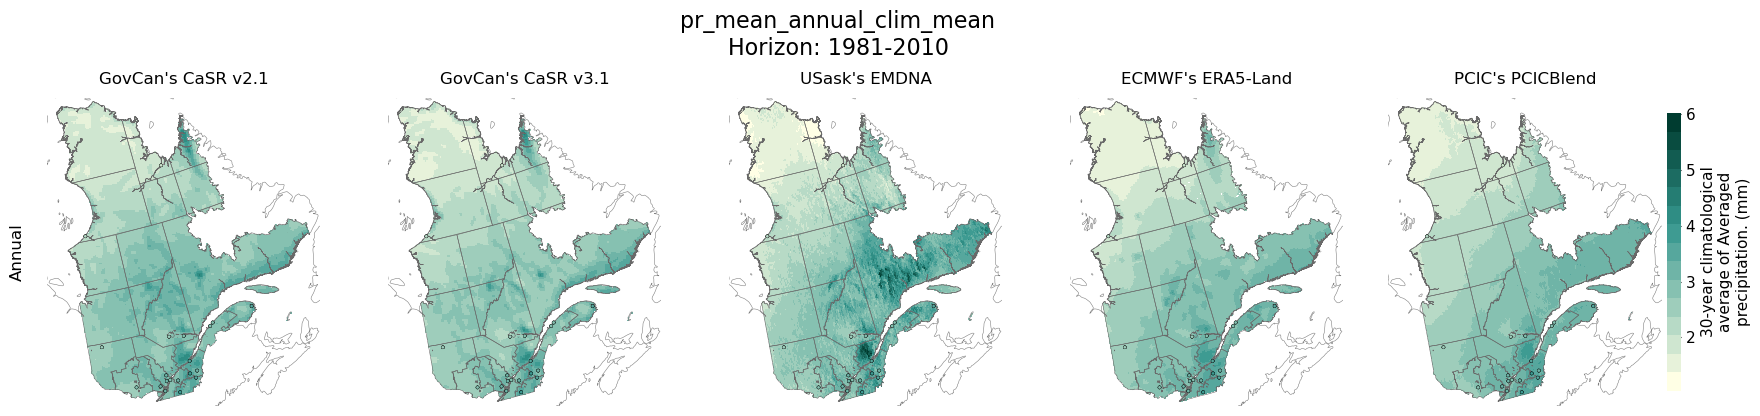

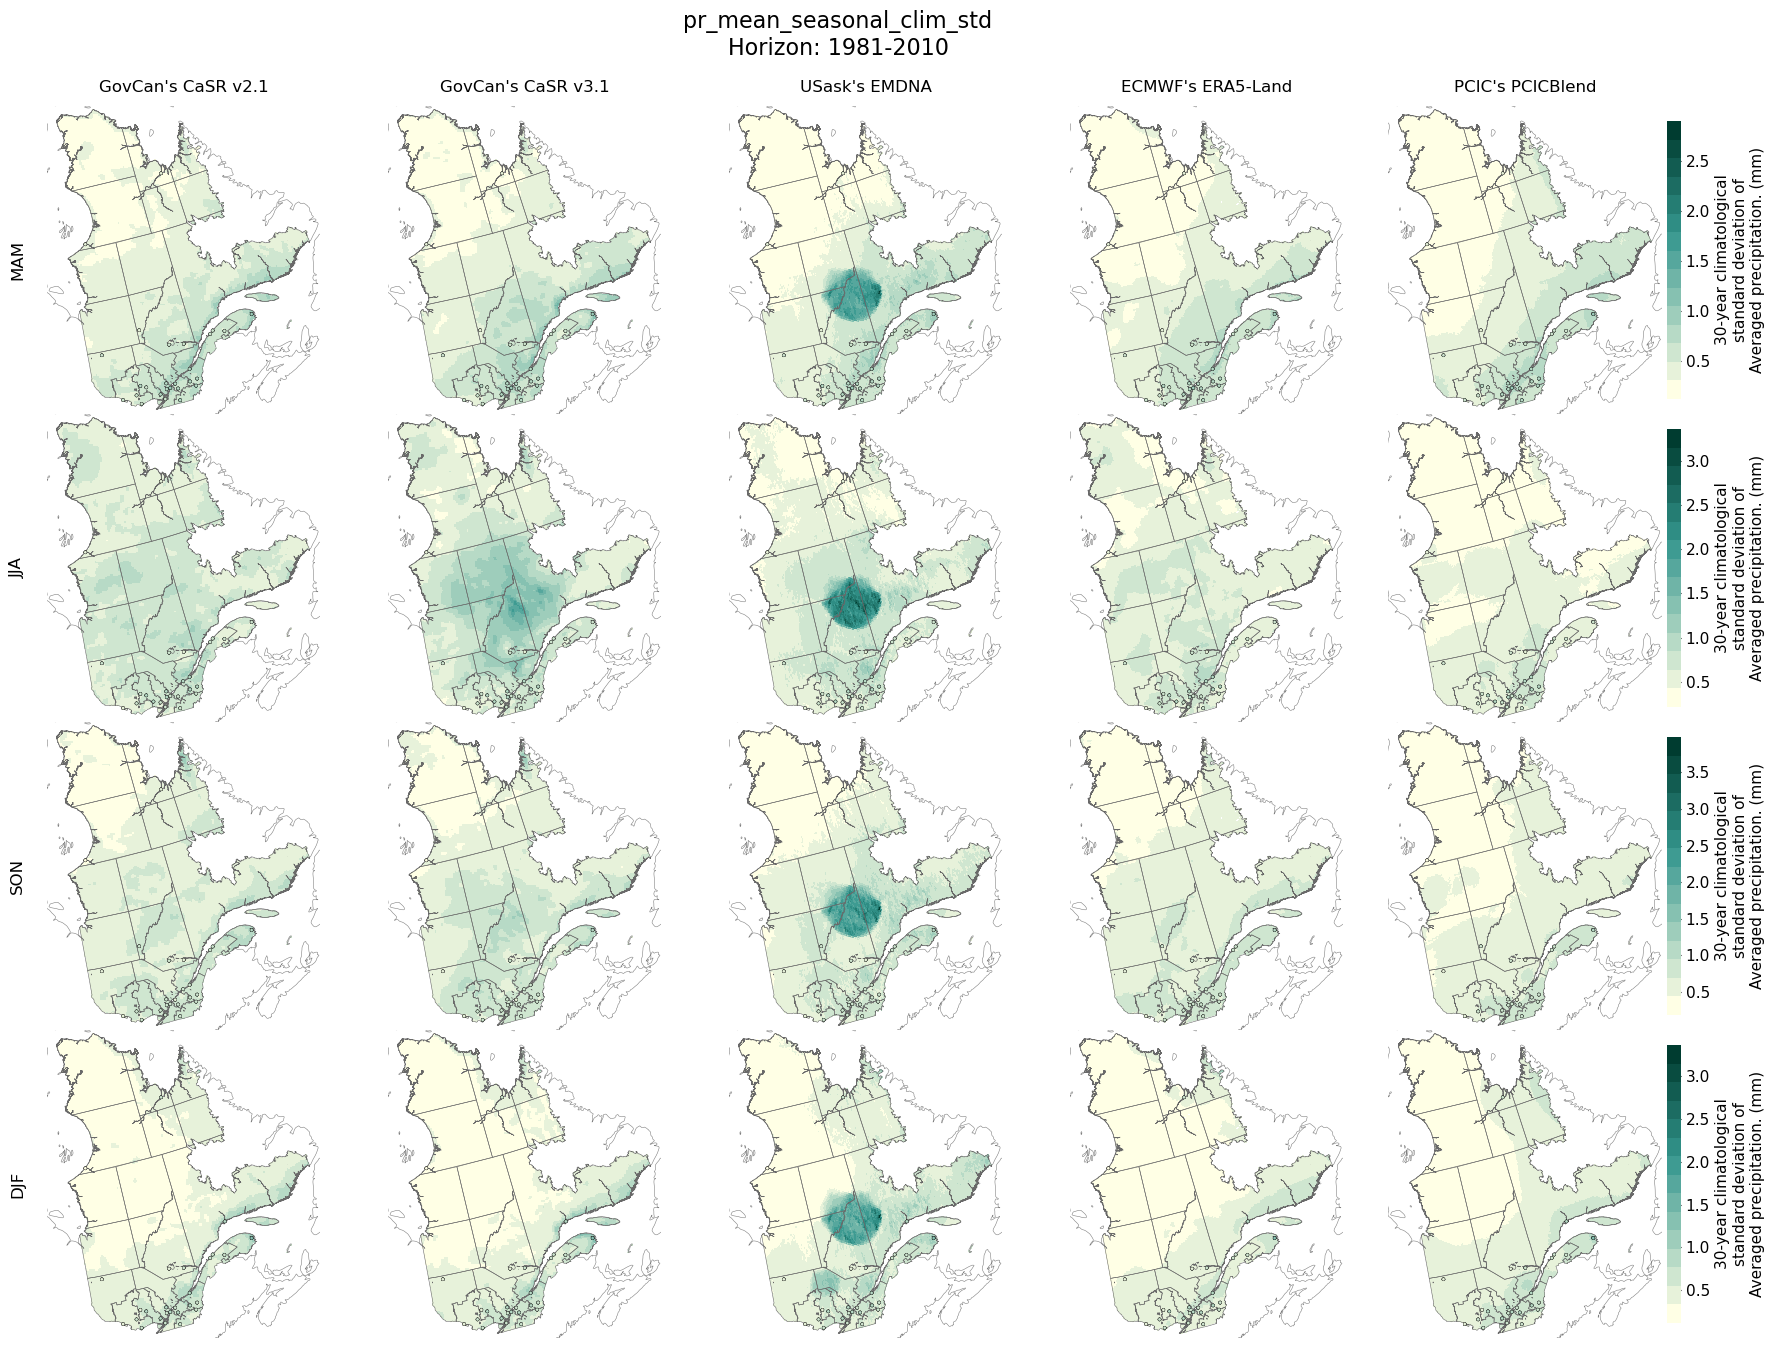

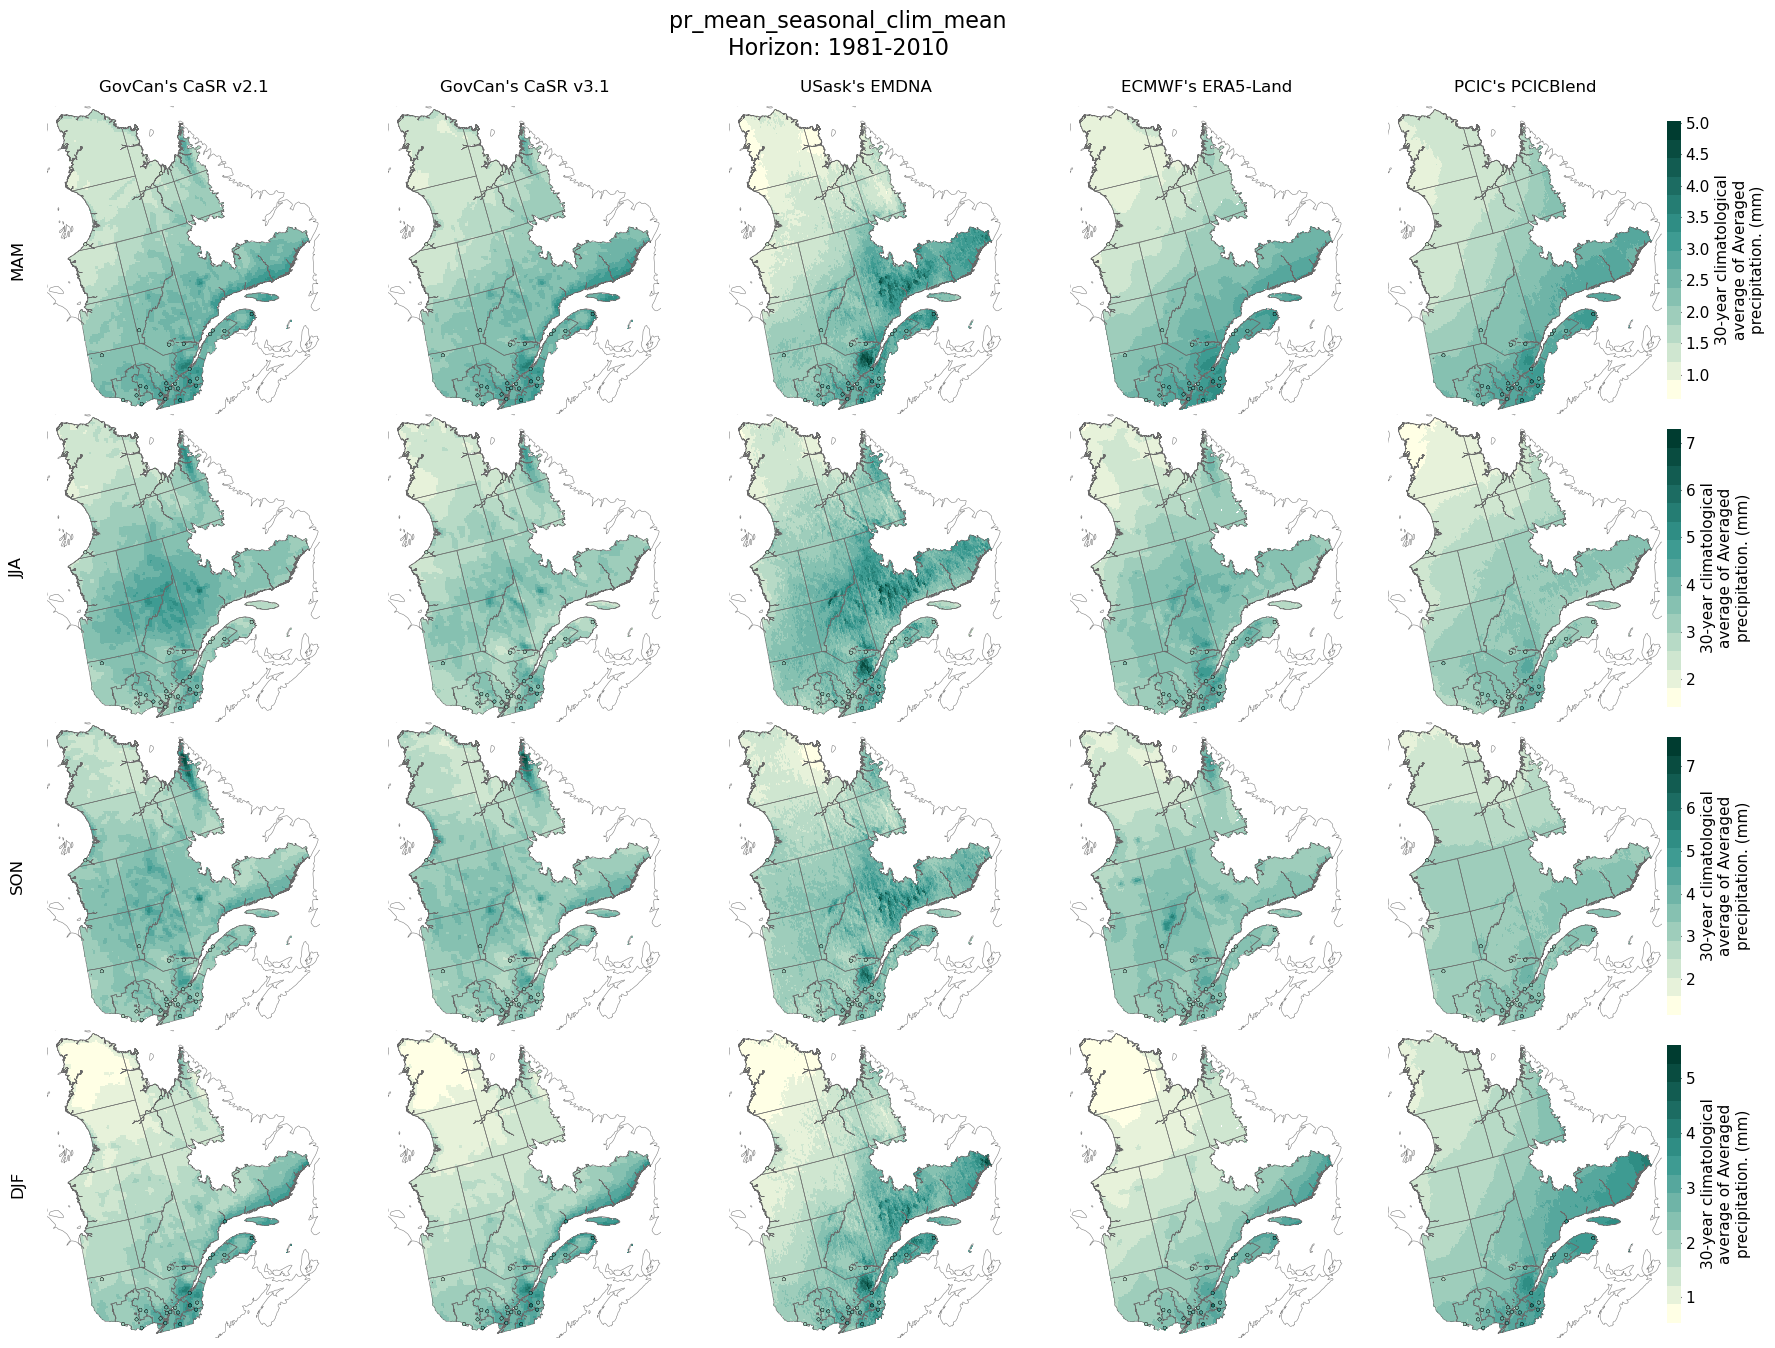

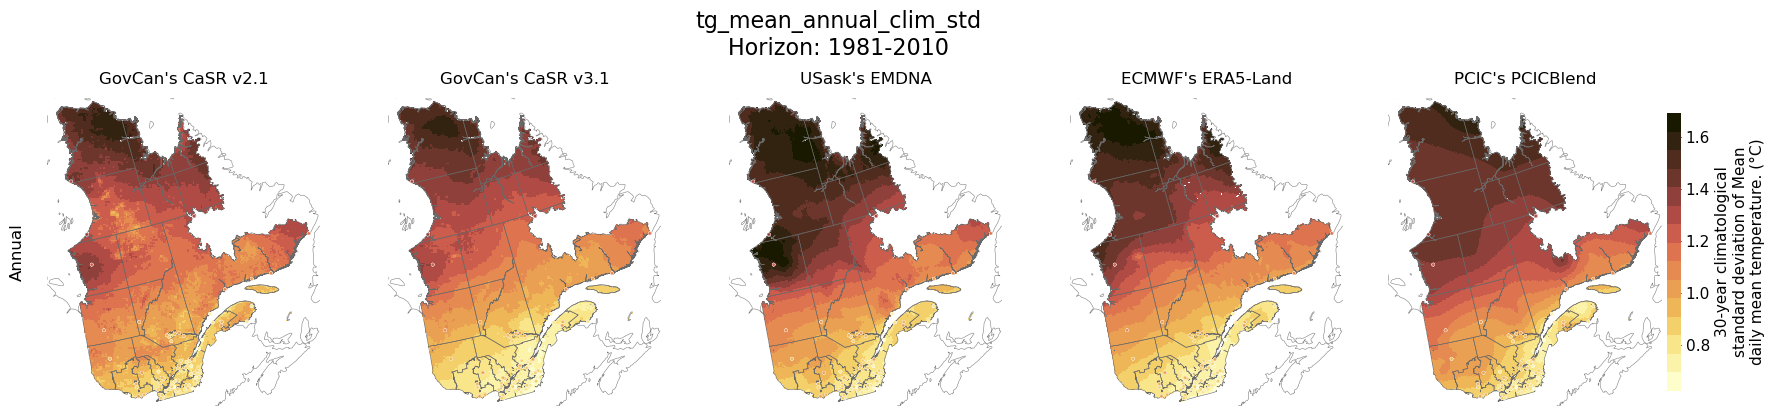

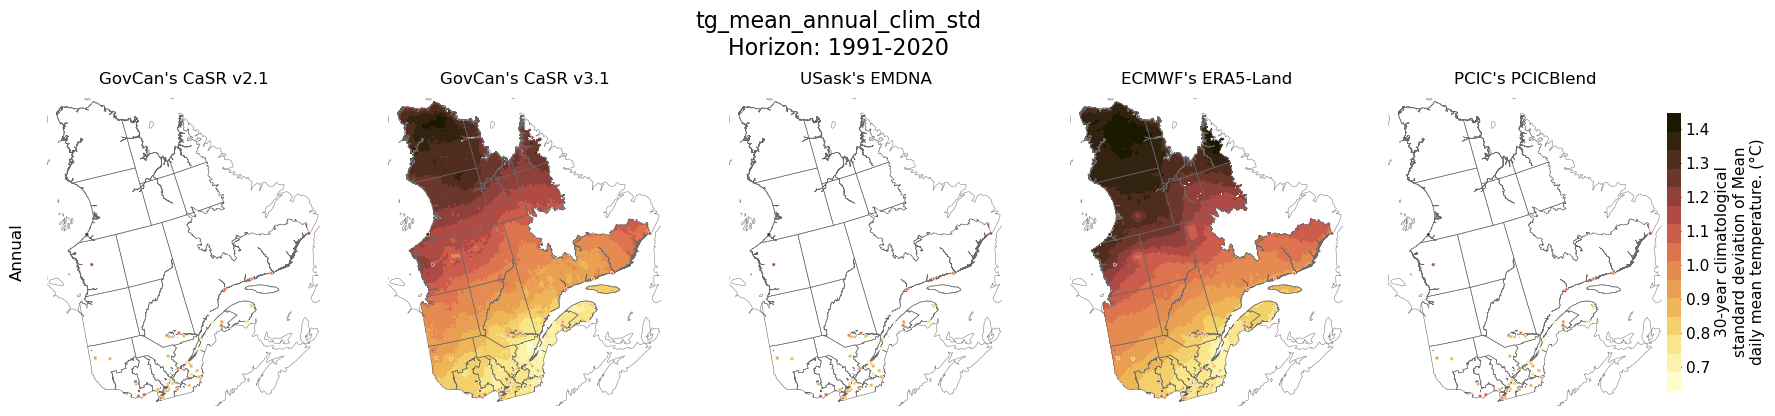

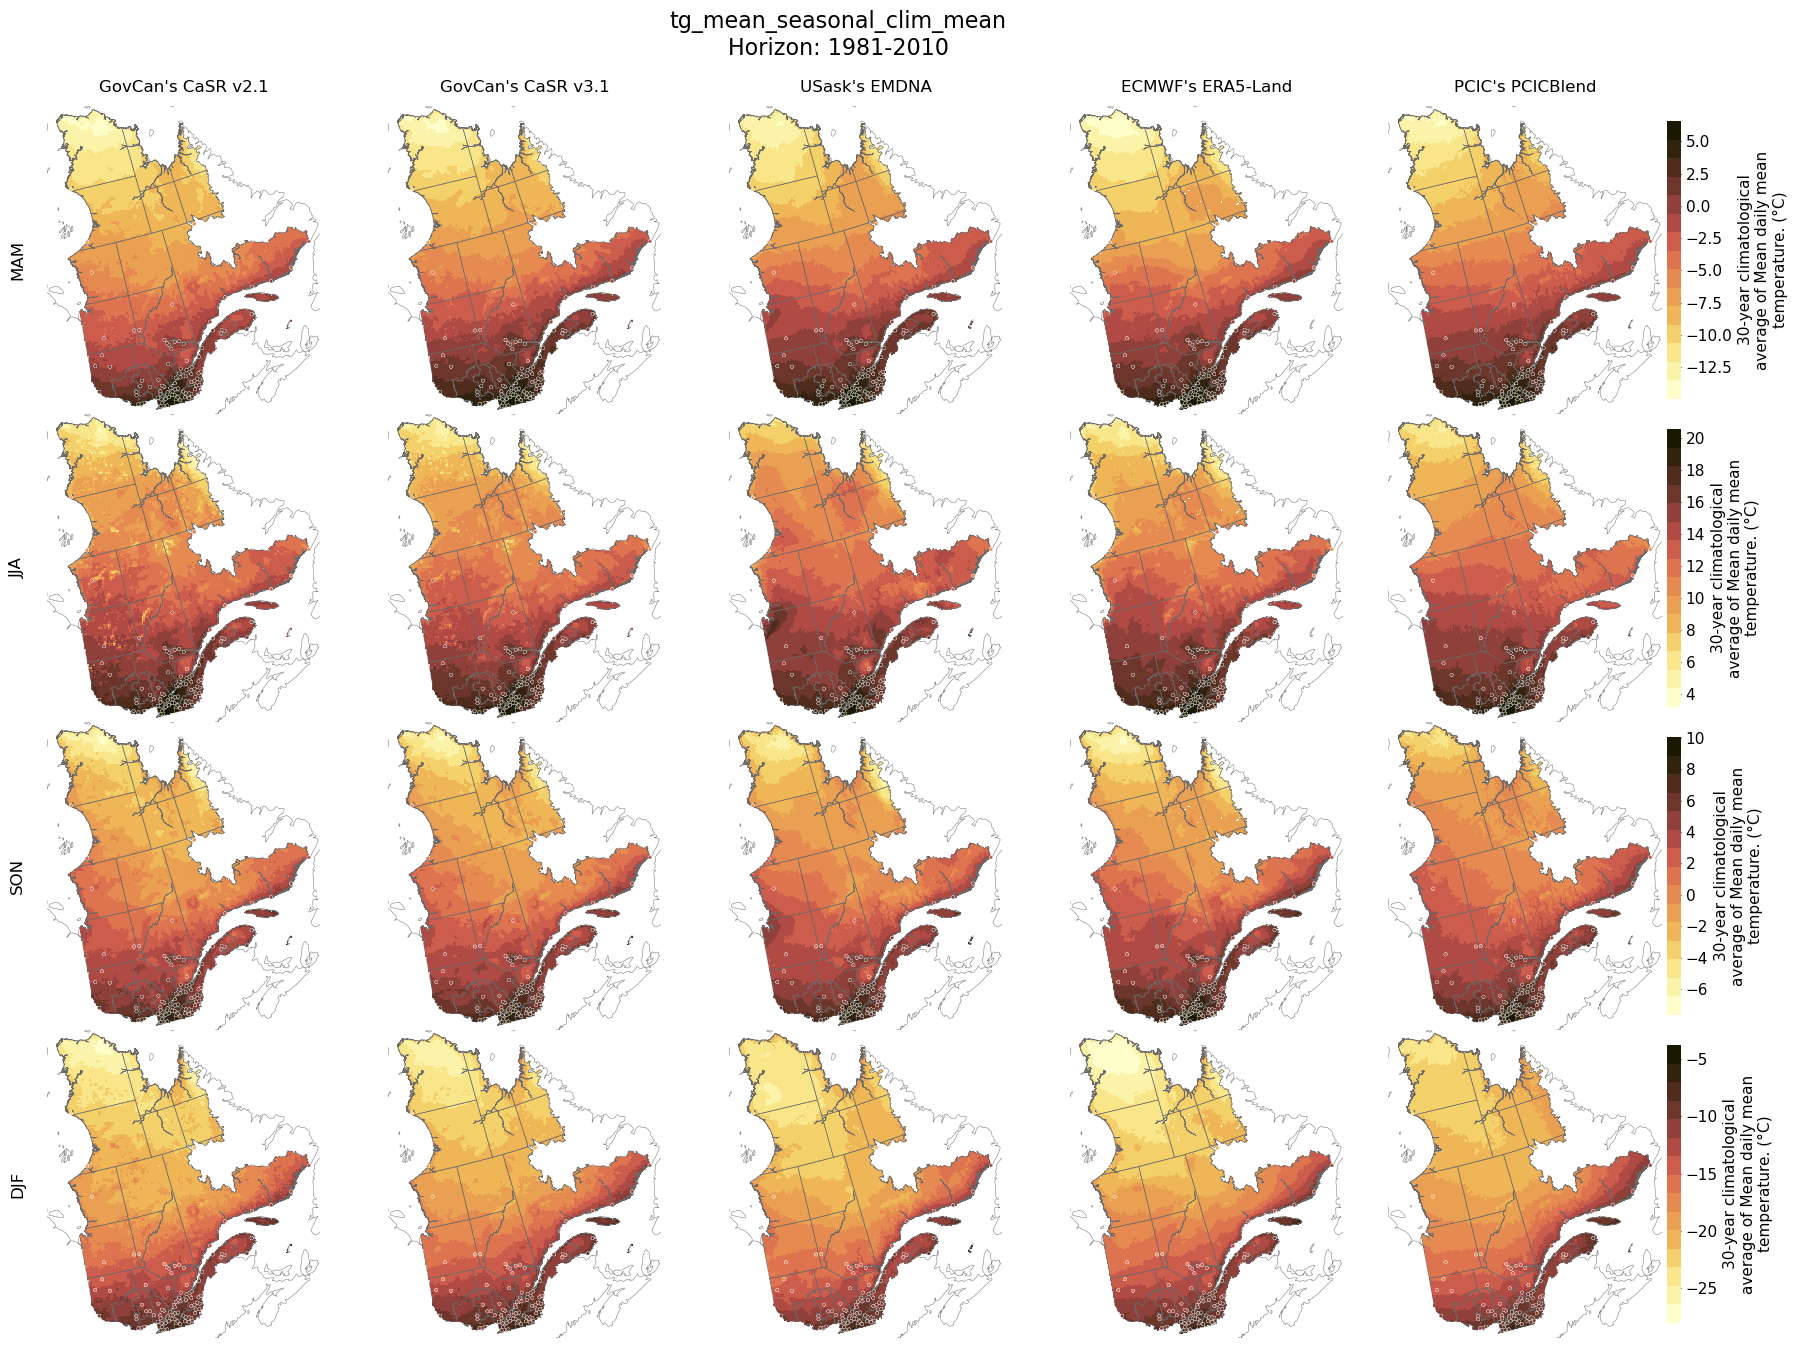

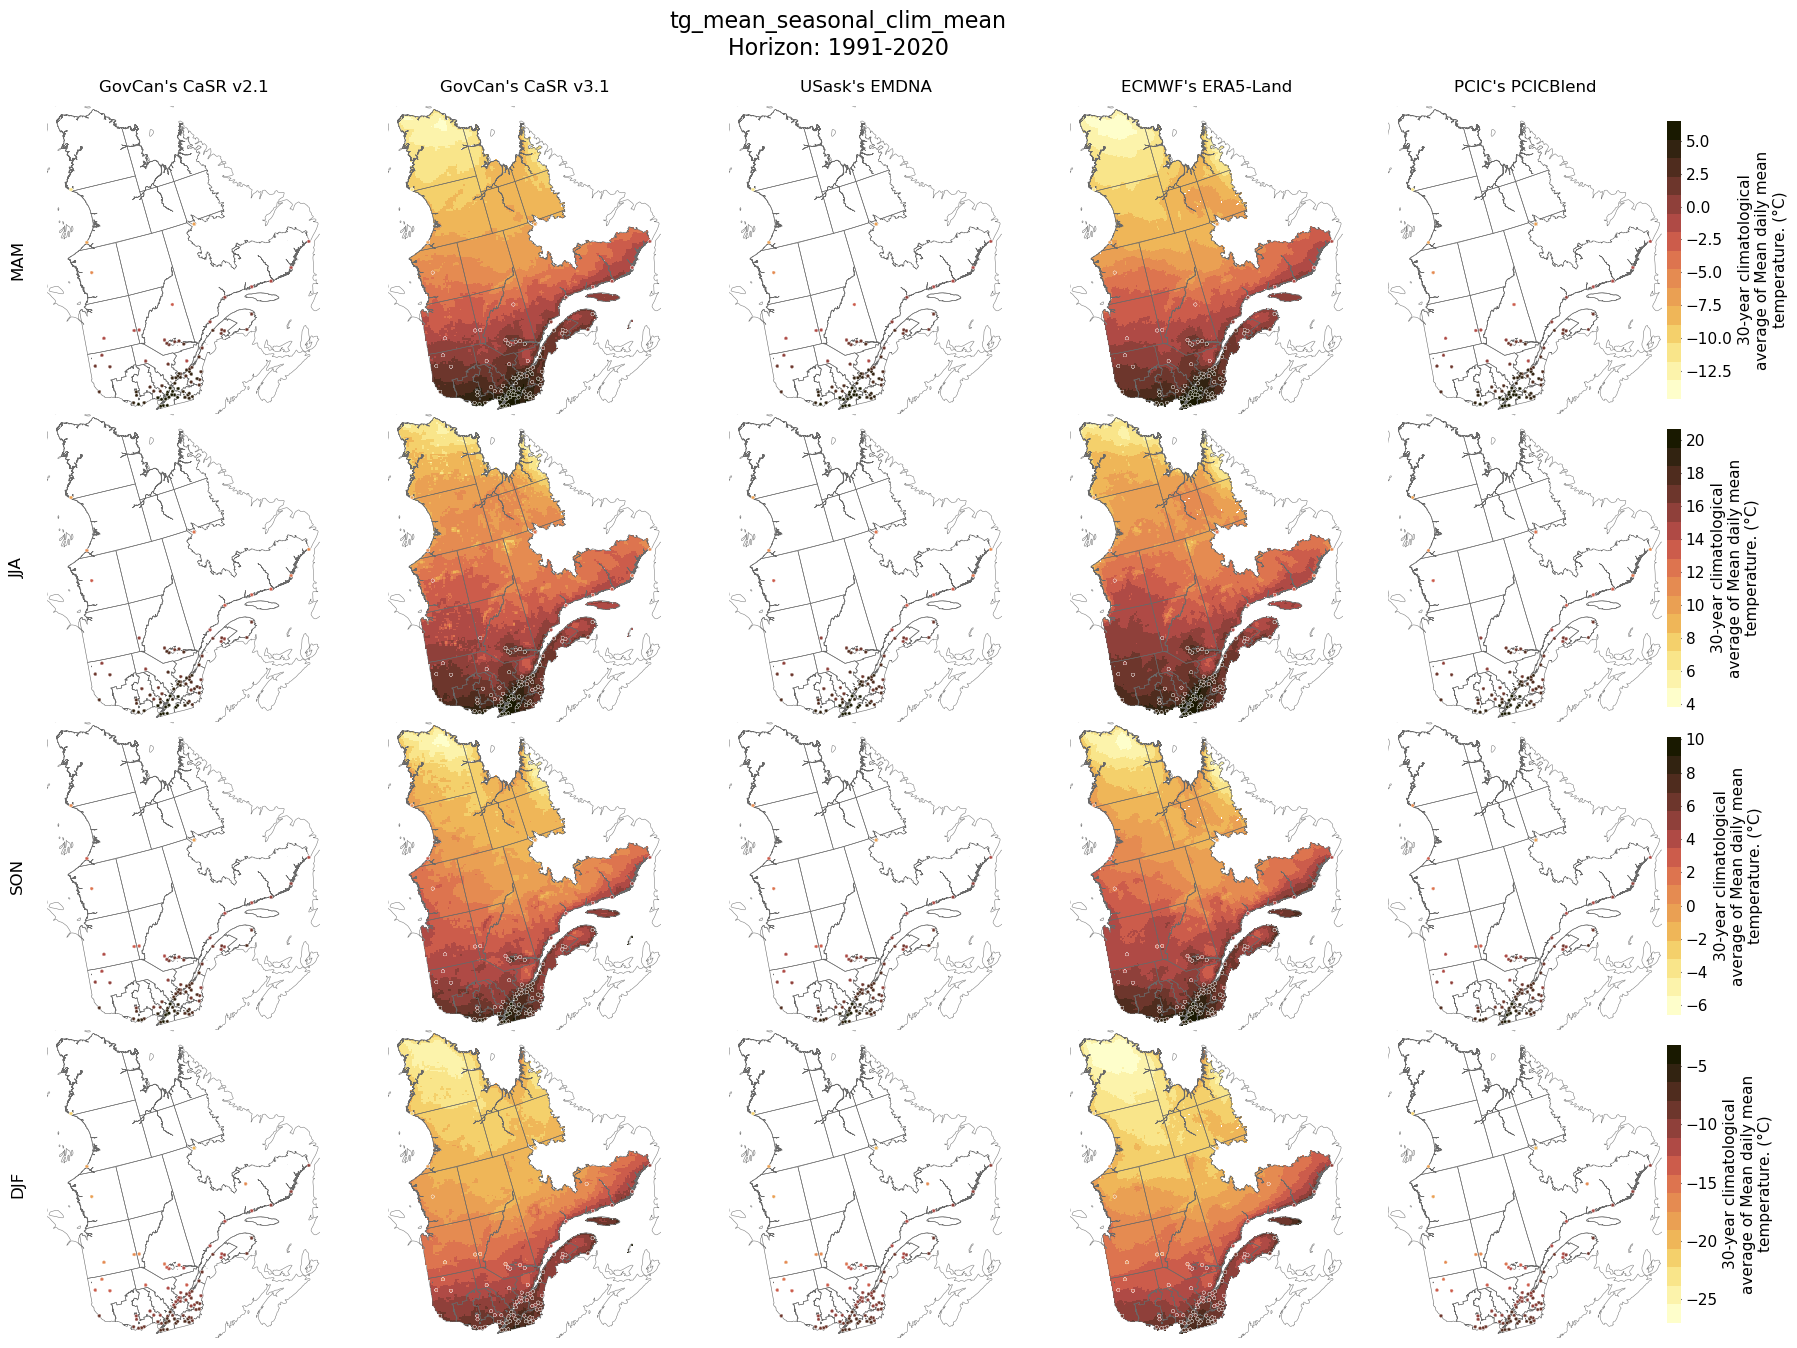

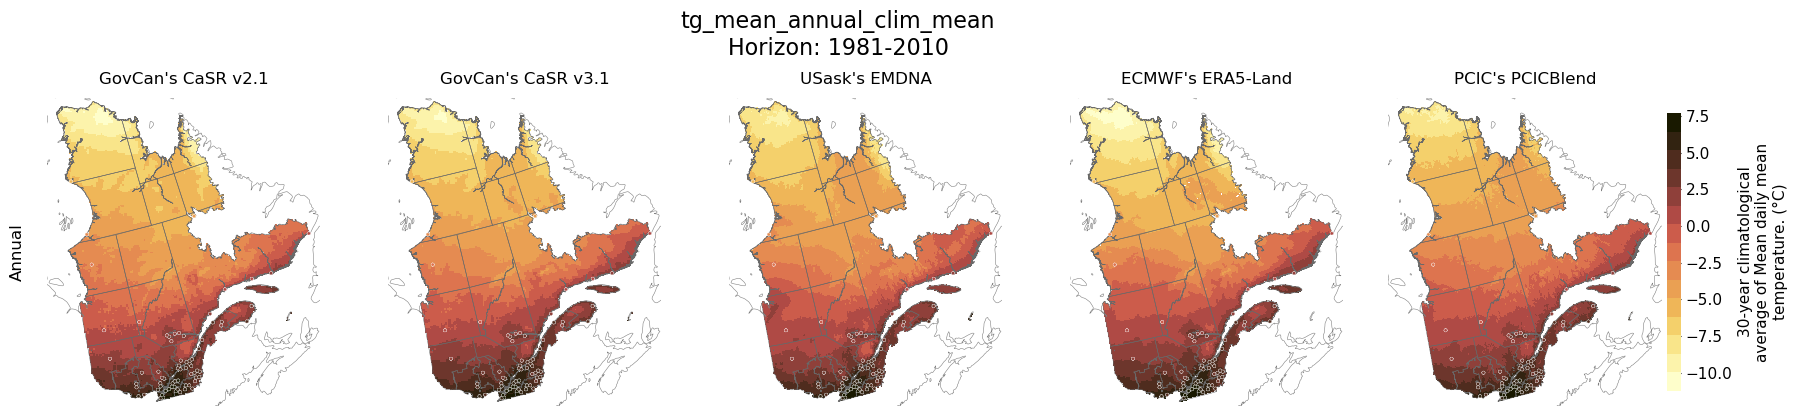

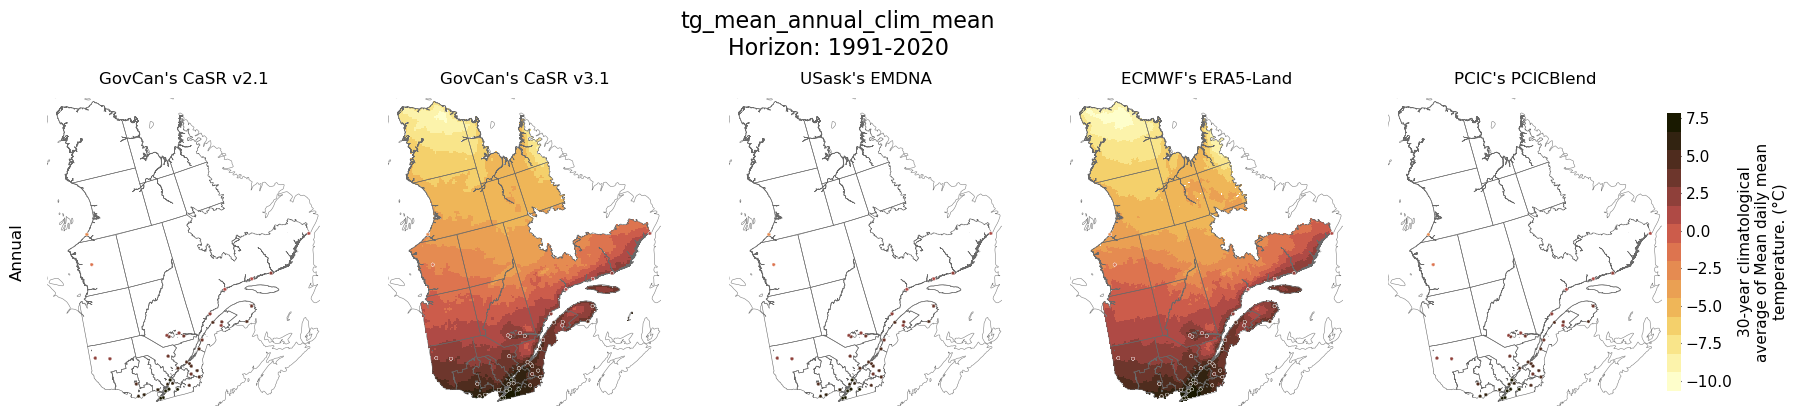

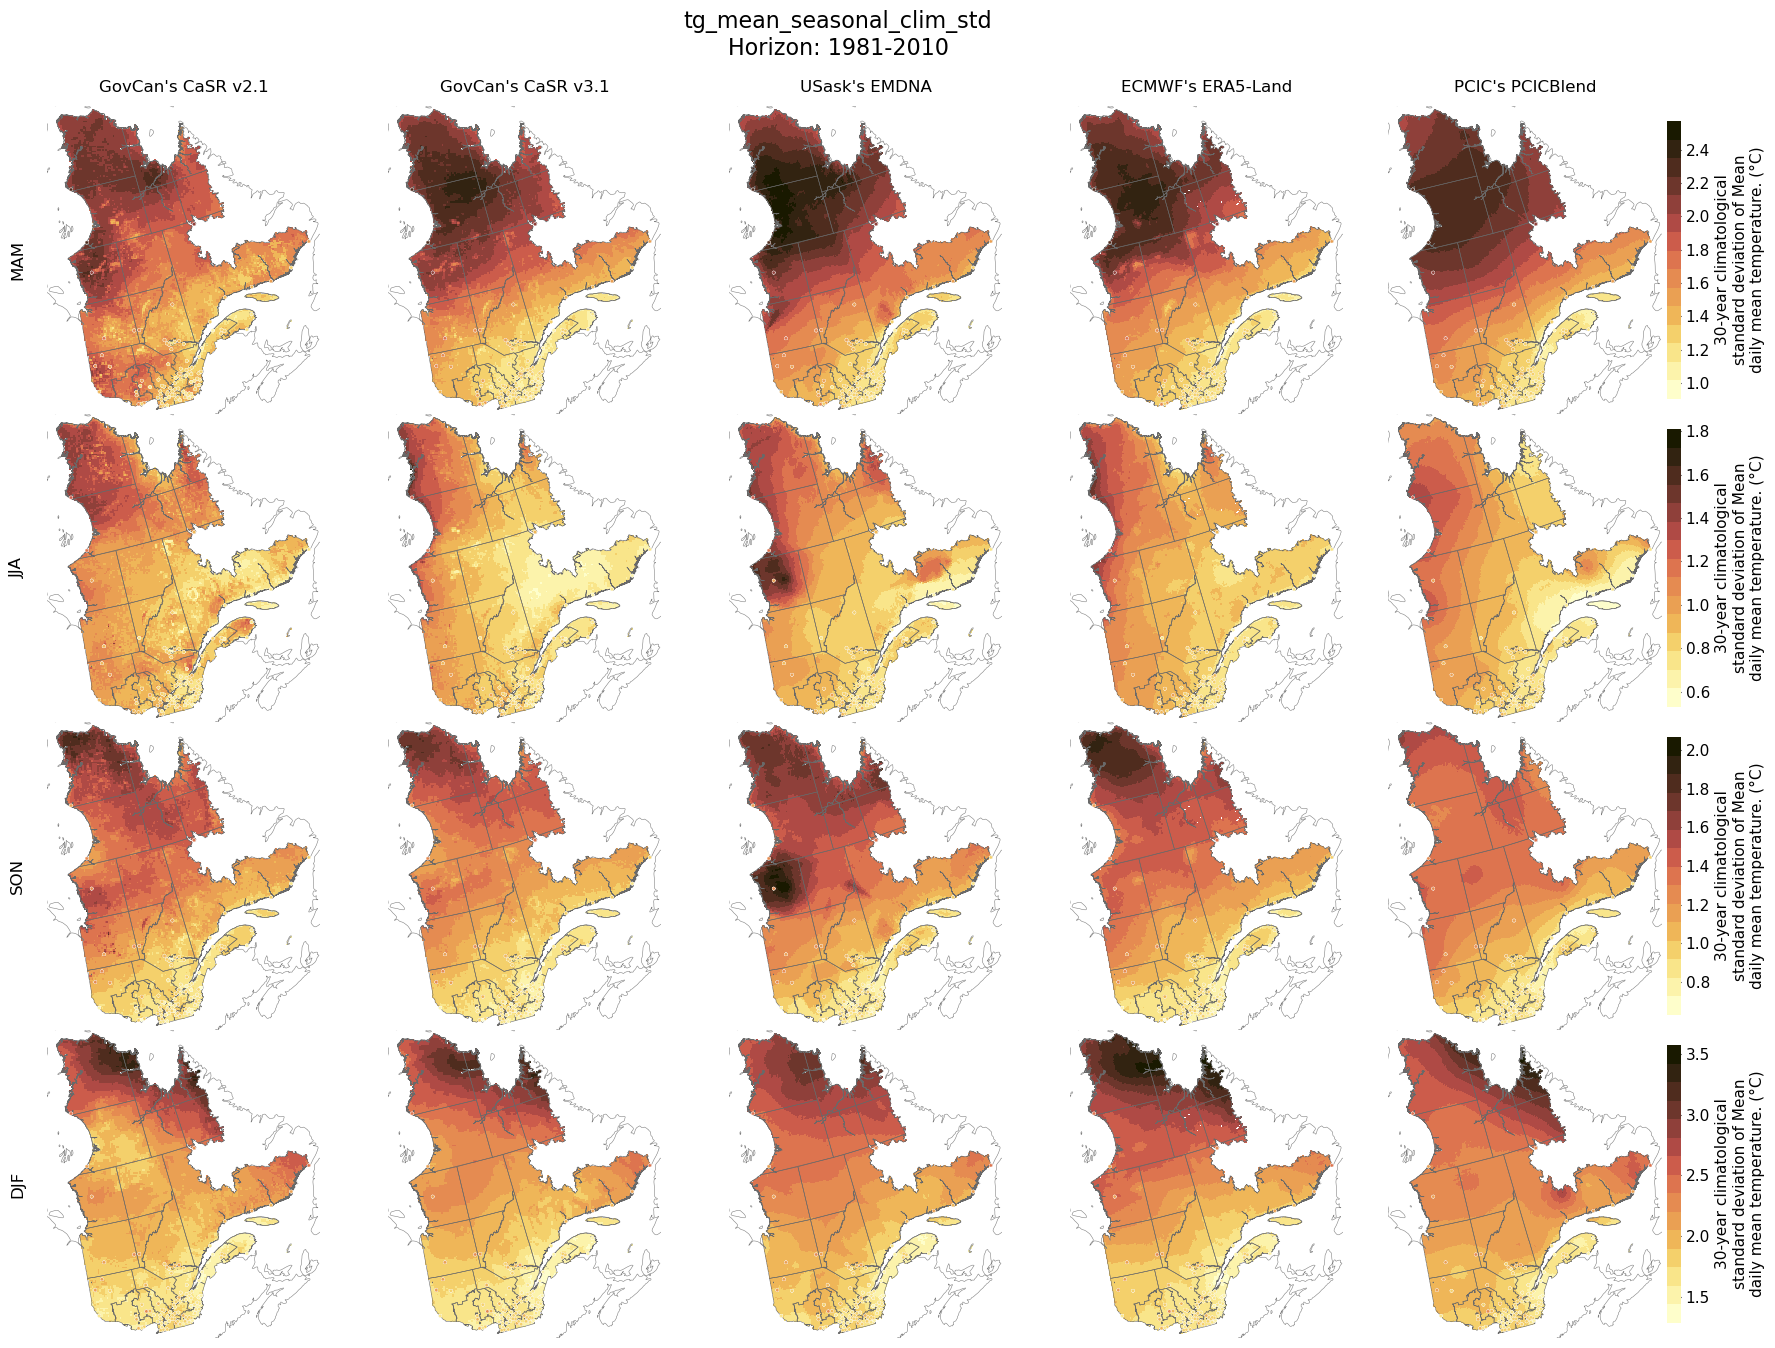

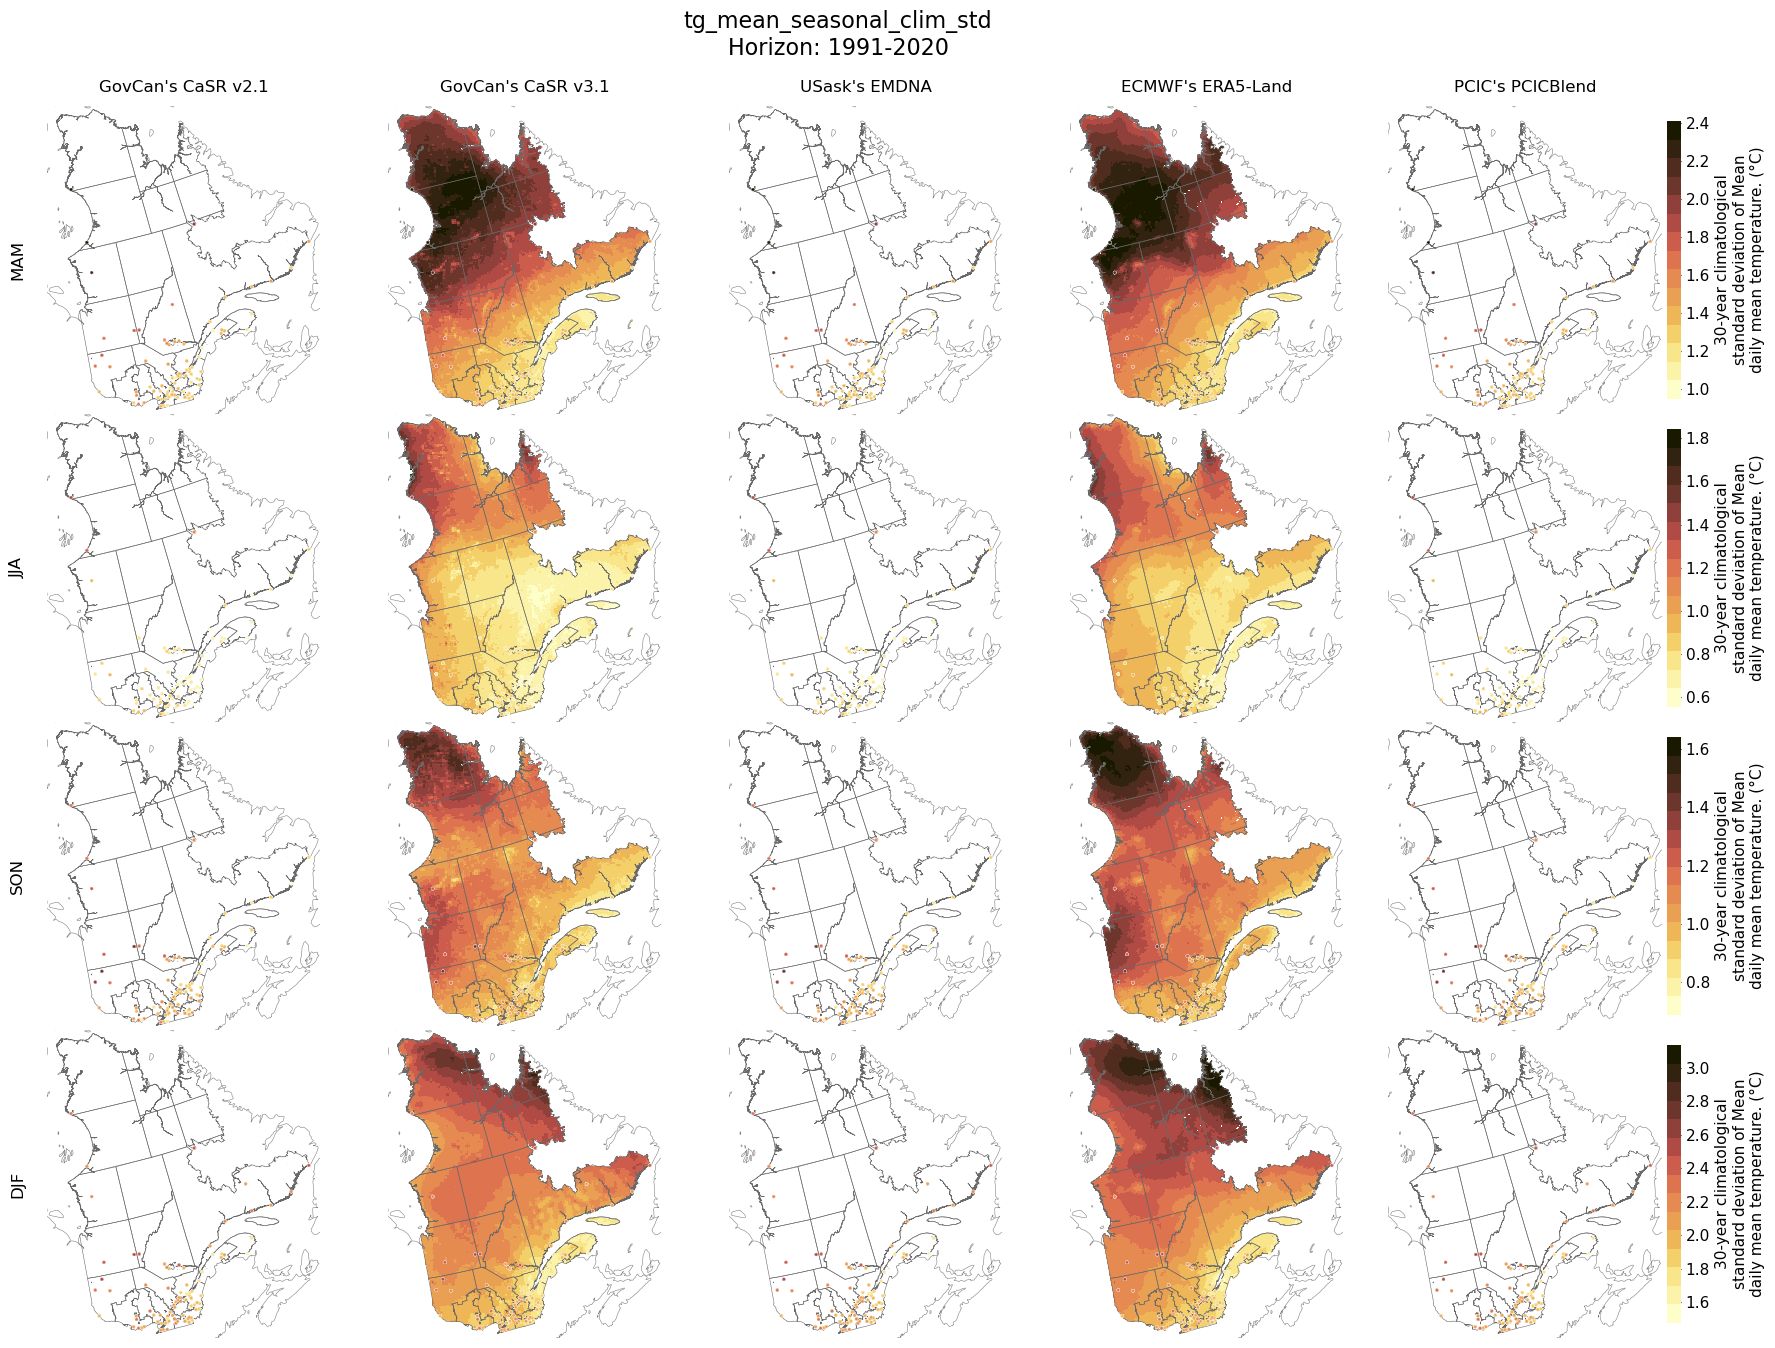

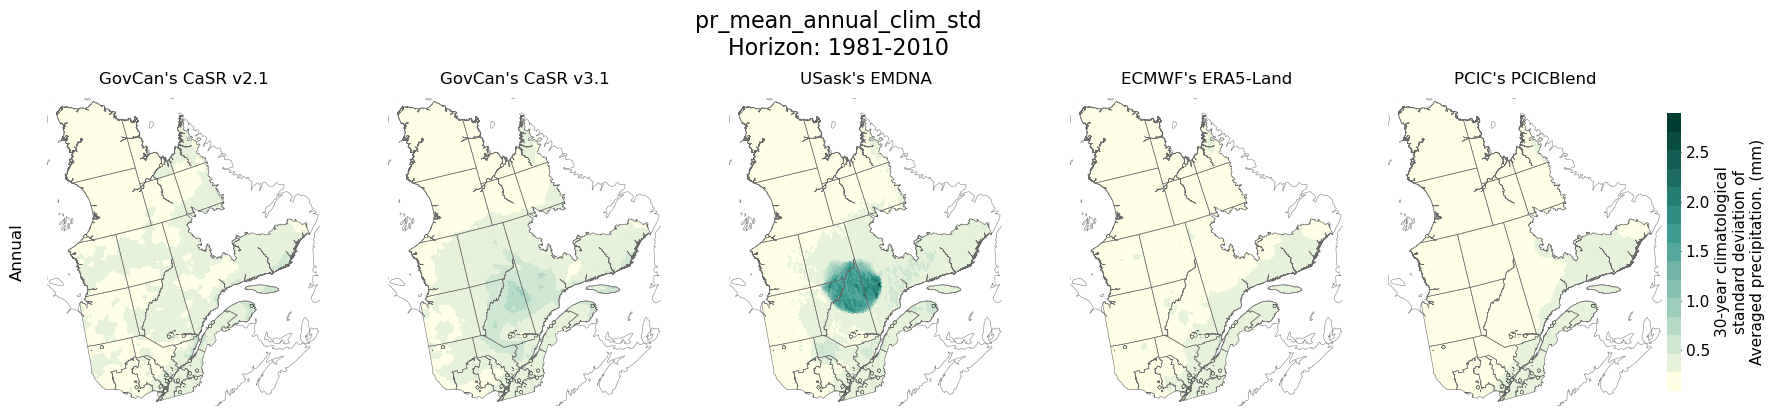

In [3]:
from figanos.matplotlib.utils import create_cmap
cmap = create_cmap("prec")

def get_valid_rec_slice(ds, var, season, horizon):
    if (
        var in ds and
        "season" in ds[var].dims and season in ds[var].season.values and
        "horizon" in ds[var].dims and horizon in ds[var].horizon.values
    ):
        return ds[var].sel(horizon=horizon, season=season).compute()
    return None

def get_global_range(obs_slice, dts_rec, valid_rec_ids, clim_var, season, horizon):
    vmin = obs_slice.min().values.item()
    vmax = obs_slice.max().values.item()
    for rec_id in valid_rec_ids:
        rec_slice = get_valid_rec_slice(dts_rec[rec_id], clim_var, season, horizon)
        if rec_slice is not None:
            vmin = min(vmin, rec_slice.min().values.item())
            vmax = max(vmax, rec_slice.max().values.item())
    return vmin, vmax

def annotate_season(ax, season_label):
    ax.annotate(
        season_label,
        xy=(-0.08, 0.5),
        xycoords='axes fraction',
        ha='right',
        va='center',
        fontsize=12,
        rotation=90
    )

def set_ax_title(ax, ds_meta):
    inst = ds_meta.attrs["cat:institution"]
    src = ds_meta.attrs["cat:source"]
    ax.set_title(f"{inst}'s {src}", fontsize=12)

# === MAIN LOOP ===
pcat_df_clim = pcat_df[pcat_df["processing_level"] == "climatology"]
variable_groups = pcat_df_clim["variable"].unique()
variables = set(item for group in variable_groups for item in group)
filtered_variables = {v for v in variables if "pr_" in v or "tg_" in v}


for clim_var in filtered_variables:
    print(f"Processing variable: {clim_var}")

    dt_obs = pcat.search(processing_level="climatology", variable=clim_var, source="AHCCD").to_dataset()
    dts_rec = pcat.search(processing_level="climatology", variable=clim_var, type="reconstruction").to_dataset_dict()

    for horizon in dt_obs.horizon.values:
        # Add fake season=annual if missing
        if "season" not in dt_obs[clim_var].dims:
            print(f"\tDetected annual data for {clim_var} - Horizon: {horizon}")
            dt_obs[clim_var] = dt_obs[clim_var].expand_dims(season=["Annual"])
            for rec_id in dts_rec:
                if clim_var in dts_rec[rec_id] and "season" not in dts_rec[rec_id][clim_var].dims:
                    dts_rec[rec_id][clim_var] = dts_rec[rec_id][clim_var].expand_dims(season=["Annual"])

        print(f"\tHorizon: {horizon}")
        obs_var = dt_obs[clim_var].sel(horizon=horizon)
        obs_var = obs_var.expand_dims(rec_ds=sorted(list(dts_rec.keys())))
        mask_nan = obs_var.isnull().compute()
        obs_valid = obs_var.where(~mask_nan, drop=True)

        n_seasons = len(obs_var.season)
        # Sort reconstruction IDs by the alphabetical order of their "cat:source" attribute
        all_rec_ids = sorted(
            dts_rec.keys(),
            key=lambda rid: dts_rec[rid].attrs.get("cat:source", "")
        )
        valid_rec_ids = [rid for rid in all_rec_ids if get_valid_rec_slice(dts_rec[rid], clim_var, obs_var.season[0].item(), horizon) is not None]
        n_models = len(all_rec_ids)

        import matplotlib.gridspec as gridspec

        fig = plt.figure(
            figsize=(4.2 * n_models + 1.0, 4.0 * n_seasons),
            constrained_layout=False
        )

        gs = gridspec.GridSpec(
            nrows=n_seasons,
            ncols=n_models,
            figure=fig,
            wspace=0.0,
            hspace=0.0
        )

        axs = np.empty((n_seasons, n_models), dtype=object)
        for i in range(n_seasons):
            for j in range(n_models):
                axs[i, j] = fig.add_subplot(gs[i, j], projection=PROJECTION)

        for i, season in enumerate(obs_var.season.values):
            season_label = str(season)
            obs_slice = obs_var.sel(season=season)

            vmin, vmax = get_global_range(obs_slice, dts_rec, valid_rec_ids, clim_var, season, horizon)
            norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            levels = np.linspace(vmin, vmax, 16)

            for j, rec_id in enumerate(all_rec_ids):
                ax = axs[i, j]

                lat_vals = obs_var.lat.values
                lon_vals = obs_var.lon.values
                is_final_column = (j == n_models - 1)

                rec_slice = get_valid_rec_slice(dts_rec.get(rec_id, {}), clim_var, season, horizon)
                if rec_slice is not None:
                    fg.gridmap(
                        rec_slice,
                        ax=ax,
                        transform=ccrs.PlateCarree() if "lat" in rec_slice.dims else None,
                        plot_kw={"norm": norm, "add_colorbar": False, "zorder": -3},
                        levels=levels,
                        frame=False,
                        show_time=False
                    )

                if "pr_" in clim_var:
                    edgecolor = "black"
                else:
                    edgecolor = "white"

                fg.scattermap(
                    obs_valid.sel(season=season).dropna(dim="station"),
                    ax=ax,
                    plot_kw={
                        "norm": norm,
                        "add_colorbar": is_final_column,
                        "cbar_kwargs": {
                            "shrink": 0.9
                        },
                        "zorder": 3,
                        "edgecolor": edgecolor,
                        "s": 5,
                        "linewidths": 0.2
                    },
                    levels=levels,
                    show_time=False,
                    frame=False
                )

                standardize(ax)

                if i == 0:
                    set_ax_title(ax, dts_rec.get(rec_id))
                else:
                    ax.set_title("")
                if j == 0:
                    annotate_season(ax, season_label)

        # Adjust suptitle position dynamically
        suptitle_y = 0.94 if n_seasons > 1 else 1.1
        fig.suptitle(f"{clim_var}\nHorizon: {horizon}", fontsize=16, y=suptitle_y)

        save_plot(fig, "climatology", horizon, freq=dt_obs.attrs["cat:xrfreq"], file_name=clim_var)



## EMDNA Blob timeseries

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.ticker import FormatStrFormatter
import figanos.matplotlib as fg

def plot_climatology_and_indicators(source, point1, point2, variable, freq):
    # === Load datasets ===
    ds_clim = pcat.search(processing_level="climatology", source=source, frequency=freq).to_dataset()
    ds_ind = pcat.search(processing_level="indicators", source=source, frequency=freq).to_dataset()

    # === Get climatology and indicators ===
    clim_var = ds_clim[f"{variable}_clim_std"].isel(horizon=0)
    ind_var = ds_ind[variable].sel(time=slice("1981", "2010"))

    # === Get point data ===
    lat1, lon1 = point1
    lat2, lon2 = point2
    ts1 = ind_var.sel(lat=lat1, lon=lon1, method="nearest")
    ts2 = ind_var.sel(lat=lat2, lon=lon2, method="nearest")

    # === Plot ===
    fig = plt.figure(figsize=(PAGE_WIDTH*2/3, PAGE_HEIGHT / 6))
    outer = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=-0.32)

    # === Left: Gridmap ===
    ax_map = fig.add_subplot(outer[1], projection=PROJECTION)
    fg.gridmap(
        clim_var,
        transform=ccrs.PlateCarree(),
        levels=15,
        frame=True,
        show_time=False,
        ax=ax_map,
        plot_kw={
            "cbar_kwargs": {
                "pad": 0.02,
                "label": clim_var.attrs.get("units", ""),
                "format": FormatStrFormatter("%.2f")
            },
            "zorder": -3
        }
    )
    ax_map.scatter(lon1, lat1, transform=ccrs.PlateCarree(), color="red", marker="x", zorder=4, s=15)
    ax_map.scatter(lon2, lat2, transform=ccrs.PlateCarree(), color="blue", marker="x", zorder=4, s=15)
    ax_map.set_title(f"{variable}_clim_std")

    # === Right: Combined Timeseries ===
    ax_ts = fig.add_subplot(outer[0])

    # Plot both timeseries on the same axis
    label1 = f"{ts1.lat.values:.2f}, {ts1.lon.values:.2f}"
    label2 = f"{ts2.lat.values:.2f}, {ts2.lon.values:.2f}"

    fg.timeseries(
        data={label1: ts1, label2: ts2},
        ax=ax_ts,
        show_lat_lon=False,
        plot_kw={label1: {"color": "red"}, label2: {"color": "blue"}}
    )
    
    # Axis labels and legend
    ax_ts.set_xlabel("Year")
    ax_ts.set_ylabel("mm")
    ax_ts.set_title(variable, fontsize=14, loc="center")
    ax_ts.set_title("", fontsize=14, loc="left")
    ax_ts.legend(loc="best", frameon=False)

    # X-axis formatting
    ax_ts.set_xticks(ts1.time.values)
    ax_ts.set_xticklabels(ts1.time.dt.year.values, rotation=70, ha="right")

    # Grid and frame
    ax_ts.grid(axis='x', linestyle='--', color='gray', alpha=0.5)
    for spine in ax_ts.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_edgecolor("black")

    standardize(ax_map)
    # Save and show
    save_plot(fig, processing_level="climatology", horizon=ds_clim.horizon[0].values, freq=freq, file_name=f"{variable}_comparison")
    plt.show()


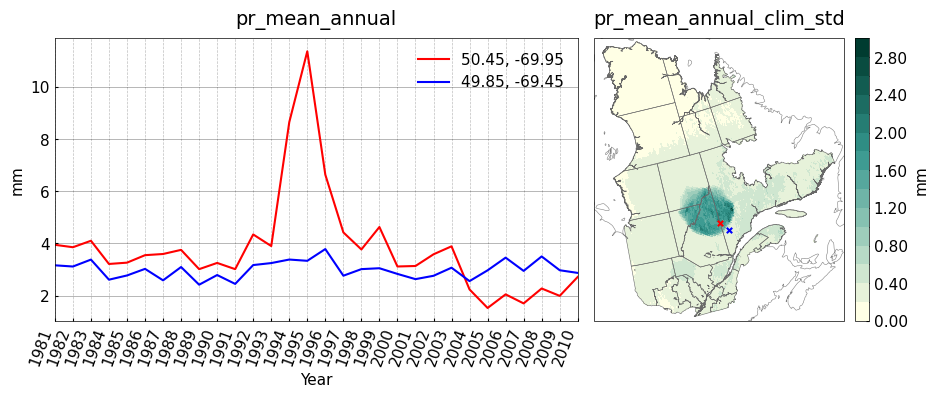

In [5]:
plot_climatology_and_indicators(
    source="EMDNA",
    point1=(50.4, -70.0),
    point2=(49.8, -69.4),
    variable="pr_mean_annual",
    freq="yr"
)